# General data reader for AQUA 
## Spatial (weighted field) averaging

When we instantiate the reader object, grid areas for the source files are computed if not already available. If regridding is requested, these are computed also for the destination grid. After this we can use the computed grid_areas to do for example spatial averaging using the `fldmean` method. 

In [1]:
import sys
sys.path.append("../..")  # hack to import module -- to be removed later

from aqua import Reader, catalogue

### Example 1: IFS


We read some IFS data

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d")
data = reader.retrieve()

tp: corrected multiplying by density of water 1000 kg m-3
tp: corrected dividing by accumulation time 10800 s


The first time the reader is instantiated, if not already available, cell area files are computed and stored in the directory specified in `config/regrid.yaml`. Notice that this operation needs to be performed once for each data source. 

The grid cell areas are available and stored in the reader. The following grid cell areas are available:
- `reader.src_grid_area`: the grid cell areas of the original grid
- `reader.dst_grid_area`: the grid cell areas of the destination grid (if regridding is used)
- `reader.grid_area`    : the source or destination grid cell areas, depending if regridding has already been performed or not


Let's pick only part of the data

In [11]:
data

<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [13]:
tas1=data.tas.isel(time=range(0,96))

We can now compute a field average and plot the resulting timeseries

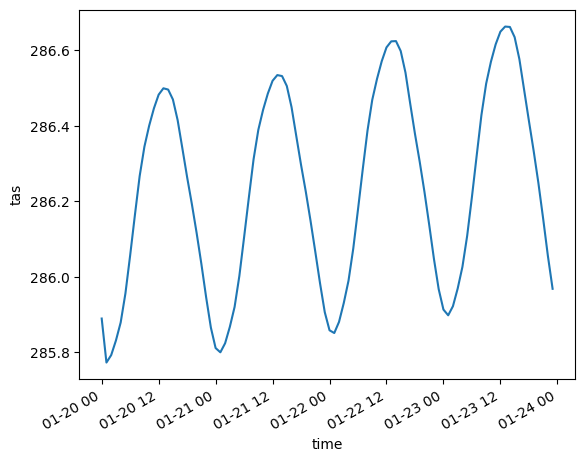

In [14]:
global_mean = reader.fldmean(tas1)
global_mean.plot()

### Example 2: ICON

Let's start without interpolation

In [3]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09")
data = reader.retrieve()

No fixes defined for model  ICON


Let's demonstrate how we can compute a timeseries of global (field) averages. Instatiating the reader has also computed grid areas (stored internally in the reader object). Since no regridding has been requested the reader assumes that we wish to work with the original data. Let's extract a short timeseries of fields. The first frame for this data source is not valid.

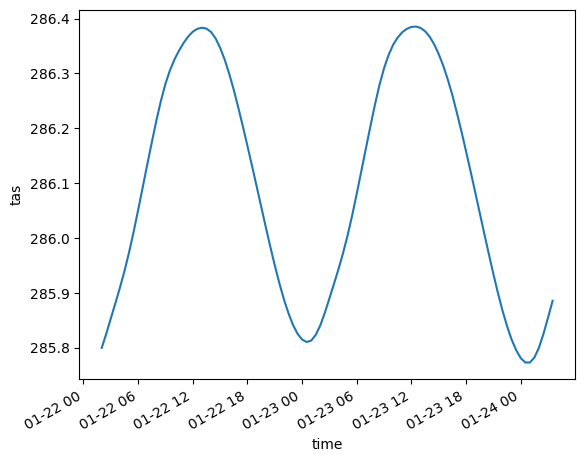

In [11]:
tas1 = data.tas[100:200,:]
global_mean = reader.fldmean(tas1)
global_mean.plot()

Now let's ask for regridding instead

Instantiate a reader for ICON data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [7]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r100")

Load the actual data. By default these data have not been regridded yet. 

You could ask to regrid them directly by specifying the argument `regrid=True` but please be warned that without a selection on dates this will take longer. It is usually more efficient to first load the data, select and then regrid.

In [8]:
data = reader.retrieve()

No fixes defined for model  ICON


Now we actually regrid part of the data

In [9]:
tasr = reader.regrid(data.tas.isel(time=range(100, 200))) 

In [19]:
tasr

<xarray.DataArray 'tas' (time: 100, lat: 180, lon: 360)>
dask.array<reshape, shape=(100, 180, 360), dtype=float64, chunksize=(6, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-22T02:00:00 ... 2020-01-24T03:30:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    regridded:                    1

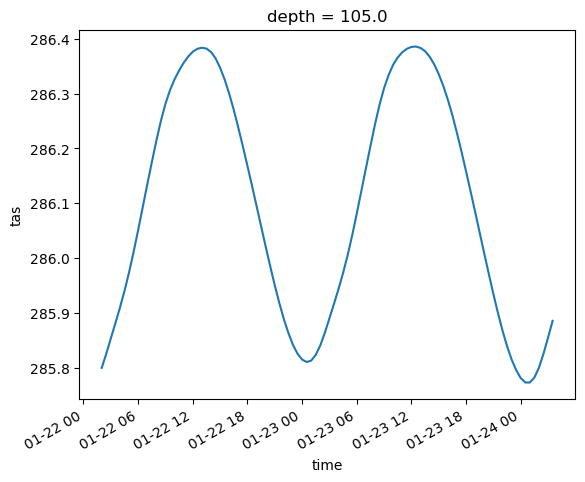

In [10]:
global_mean_r = reader.fldmean(tasr)
global_mean_r.plot()


How much do the global averages done on the interpolated and original fields differ ?

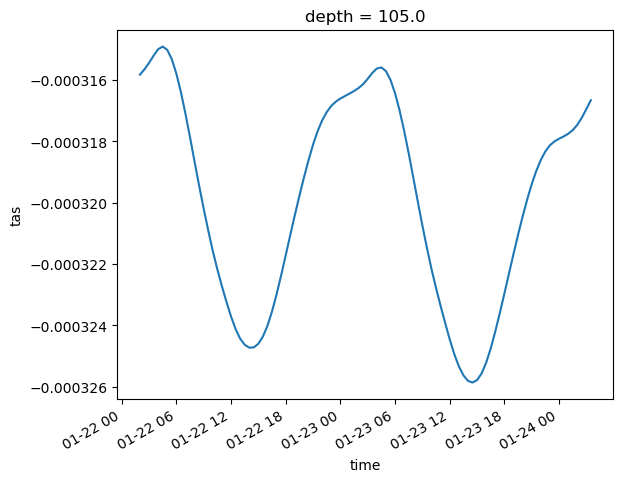

In [12]:
(global_mean - global_mean_r).plot()

The same average could have been performed directly using the cell areas:

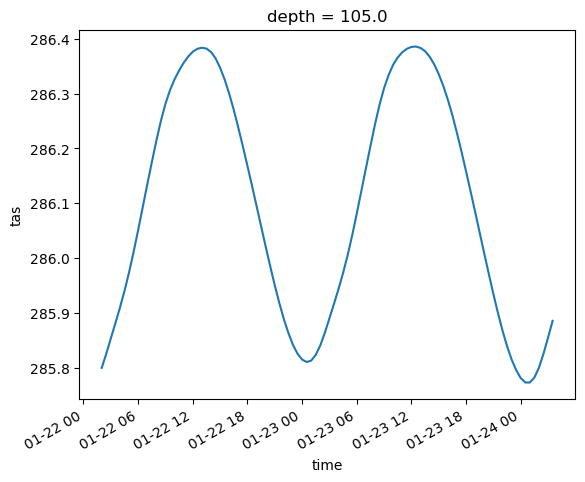

In [22]:
tasr.weighted(weights=reader.dst_grid_area).mean(dim=reader.dst_space_coord).plot()

### Example 3: Healpix data (ICON)

We can also read healpix data. Healpix implements the `zoom` parameter. `zoom=9` (default) is 12.5 Km, every lower number halves resolution. 

In [14]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="hpx", zoom=9, regrid="r100")
data = reader.retrieve()

Source areas file not found: /work/bb1153/b382075/nextgems/weights/areas_ICON_hpx_result.nc
Attempting to generate it ...
Source grid:  /work/bb1153/b382075/nextgems/grids/icon_hpx0.nc
Success!
No fixes defined for model  ICON


area weighting (of original data)

In [15]:
tas1 = data.tas.isel(time=range(0,1000))

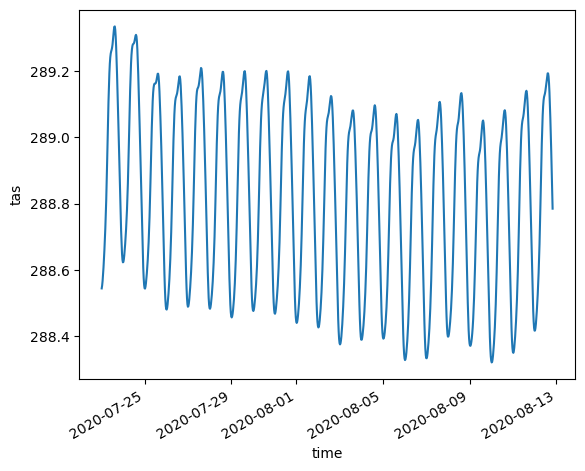

In [16]:
reader.fldmean(tas1).plot()

### Example 4: Hi-res interpolated FESOM data - no further interpolation

In [23]:
from aqua import Reader, catalogue
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS")
data = reader.retrieve()

We compute spatial field averages: 

In [24]:
to1 = data.to.isel(time=range(0,96)).isel(depth=0)

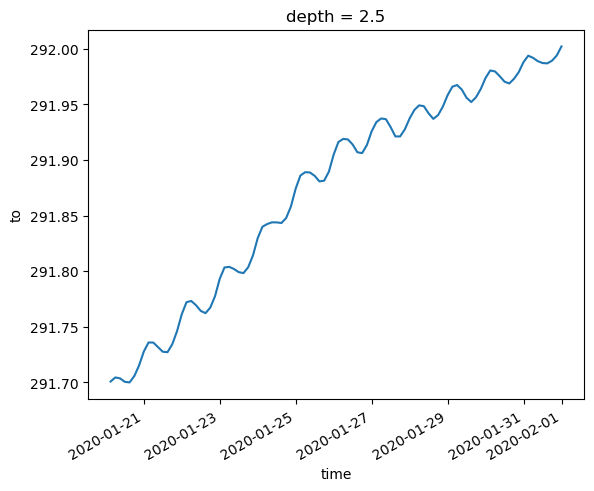

In [25]:
global_mean_r = reader.fldmean(to1)
global_mean_r.plot()


### Example 5: Hi-res interpolated FESOM data - with further interpolation

These are masked 3d data. For now (working on it), we can only interpolate one level at the time. So a level has to be specified and the retrieve method will only provide data from that level. An error is raised if level is not specified in this case.

In [26]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS", regrid="r100", level=20)

In [27]:
data = reader.retrieve()

Let's try a timeseries of regridded data

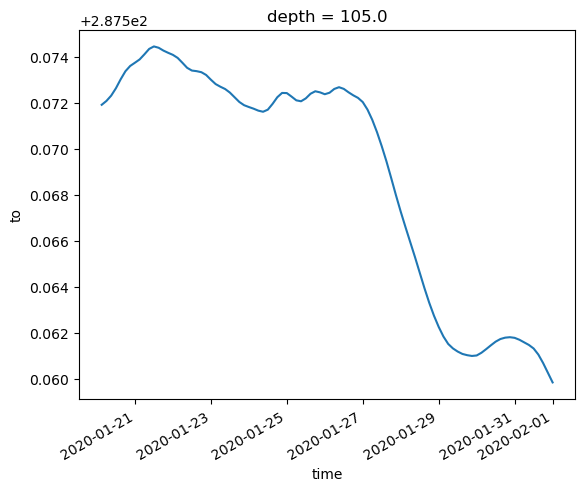

In [30]:
tr1 = data.to.isel(time=range(0,96))
global_mean_r = reader.fldmean(tr1)
global_mean_r.plot()


### Example 6: Original FESOM data - further interpolation

In [31]:
from aqua import Reader, catalogue
reader = Reader(model="FESOM", exp="tco2559-ng5", source="original_2d", regrid="r250")

In [32]:
data = reader.retrieve()

A timeseries directly from the original data:

(8328, 7402886)


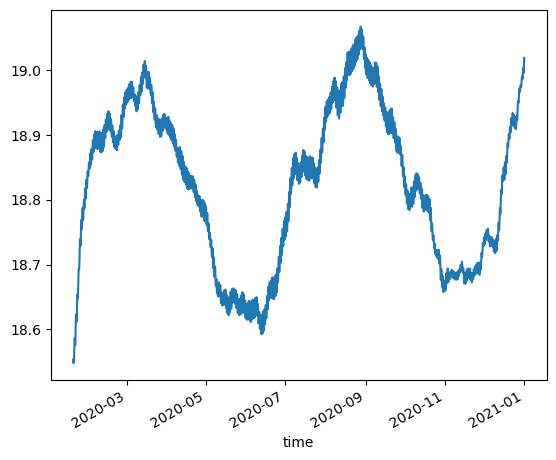

In [15]:
sst=data.sst.isel(time=range(0,8328))
reader.fldmean(sst).plot()